In [1]:
!pip install Keras-Preprocessing

In [2]:
!pip install kagglehub

In [3]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import kagglehub
import os

c:\Users\Daniel Crispalito\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Daniel Crispalito\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [5]:
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

In [6]:
print(os.listdir(train_dir))

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


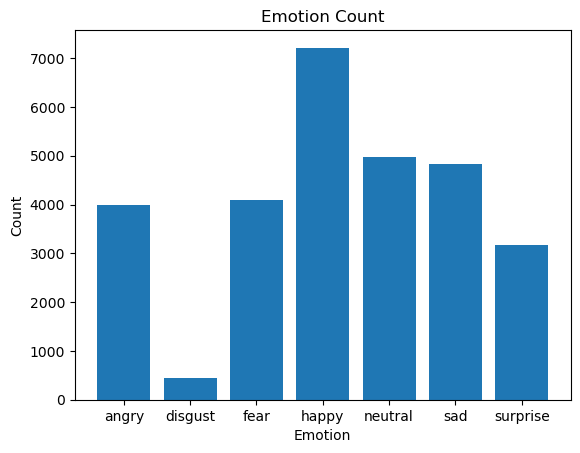

Emotion : 
  angry: 3995
  disgust: 436
  fear: 4097
  happy: 7215
  neutral: 4965
  sad: 4830
  surprise: 3171


In [7]:

import matplotlib.pyplot as plt

emotion_count = {}
for emotion in os.listdir(train_dir):
    emotion_path = os.path.join(train_dir, emotion)
    emotion_count[emotion] = len(os.listdir(emotion_path))

plt.bar(emotion_count.keys(), emotion_count.values())
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Count")
plt.show()

print("Emotion : ")
for emotion in os.listdir(train_dir):
    print(f"  {emotion}: {len(os.listdir(os.path.join(train_dir, emotion)))}")

In [8]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

def load_dataset(directory):
    images = []
    labels = []

    emotion_labels = sorted(os.listdir(directory))
    print(f"Loading images from: {directory}")

    for idx, emotion in enumerate(emotion_labels):
        emotion_path = os.path.join(directory, emotion)
        print(f"  Processing emotion: {emotion} ({idx}/{len(emotion_labels)})")
        for img_file in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_file)

            img = load_img(img_path, color_mode="grayscale", target_size=(IMG_WIDTH, IMG_HEIGHT))
            img_array = np.array(img)
            images.append(img_array)
            labels.append(idx)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


Load Dataset for Training

In [9]:
X_all_train_raw, y_all_train_raw = load_dataset(train_dir)
X_test_raw, y_test_raw = load_dataset(test_dir)

Loading images from: C:\Users\Daniel Crispalito\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train
  Processing emotion: angry (0/7)
  Processing emotion: disgust (1/7)
  Processing emotion: fear (2/7)
  Processing emotion: happy (3/7)
  Processing emotion: neutral (4/7)
  Processing emotion: sad (5/7)
  Processing emotion: surprise (6/7)
Loading images from: C:\Users\Daniel Crispalito\.cache\kagglehub\datasets\msambare\fer2013\versions\1\test
  Processing emotion: angry (0/7)
  Processing emotion: disgust (1/7)
  Processing emotion: fear (2/7)
  Processing emotion: happy (3/7)
  Processing emotion: neutral (4/7)
  Processing emotion: sad (5/7)
  Processing emotion: surprise (6/7)


Encoding Label (One - Hot Encoding Label)

In [10]:
NUM_CLASSES = len(sorted(os.listdir(train_dir)))
y_all_train_encoded = to_categorical(y_all_train_raw, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test_raw, num_classes=NUM_CLASSES)

Split Dataset into training and validation

In [29]:
X_train_raw_split, X_val_raw_split, y_train_split, y_val_split = train_test_split(
    X_all_train_raw, y_all_train_encoded,
    test_size=0.2,
    random_state=42,
)

Normalisasi dan Reshape

In [30]:
X_train = X_train_raw_split.astype('float32') / 255.0 
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) 
y_train = y_train_split 

# Data Validasi (untuk Monitoring)
X_val = X_val_raw_split.astype('float32') / 255.0 
X_val = X_val.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) 
y_val = y_val_split 

# Data Testing (untuk Evaluasi Akhir)
X_test = X_test_raw.astype('float32') / 255.0 
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_test = y_test_encoded 

print(f"\n--- Data Prapemrosesan Selesai ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


--- Data Prapemrosesan Selesai ---
X_train shape: (22967, 48, 48, 1), y_train shape: (22967, 7)
X_val shape: (5742, 48, 48, 1), y_val shape: (5742, 7)
X_test shape: (7178, 48, 48, 1), y_test shape: (7178, 7)


Menghitung Bobot Untuk Masing - masing kelas

In [13]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# np.argmax(..., axis=1) akan mengembalikan indeks (0 sampai 6) dari nilai 1 di setiap baris OHE.
y_train_labels = np.argmax(y_train, axis=1)
classes = np.arange(NUM_CLASSES)

class_weights_array = compute_class_weight(
    class_weight='balanced', 
    classes=classes,
    y=y_train_labels
)
# 4. Mengubah array bobot menjadi format dictionary yang dibutuhkan Keras
class_weights = dict(enumerate(class_weights_array))

MMembuat  Model

In [14]:
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)
BATCH_SIZE = 128
EPOCHS = 50

def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Arsitektur (Deep CNN dengan BN dan Dropout)
    # Blok 1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Blok 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Blok 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Fully Connected (Dense) Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Kompilasi Model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

model = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)

c:\Users\Daniel Crispalito\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation (Membantu mencegah overfitting)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Callbacks
checkpoint = ModelCheckpoint('best_fer2013_model.keras',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_lr=0.00001)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


Training Model

In [16]:
print("\n--- Memulai Pelatihan Model ---")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
   # steps_per_epoch=len(X_train) // BATCH_SIZE,
    class_weight=class_weights,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)


--- Memulai Pelatihan Model ---
Epoch 1/50


c:\Users\Daniel Crispalito\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1728 - loss: 2.5997
Epoch 1: val_accuracy improved from -inf to 0.02125, saving model to best_fer2013_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.1729 - loss: 2.5984 - val_accuracy: 0.0212 - val_loss: 2.4697 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.2376 - loss: 2.0478
Epoch 2: val_accuracy improved from 0.02125 to 0.21978, saving model to best_fer2013_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.2377 - loss: 2.0475 - val_accuracy: 0.2198 - val_loss: 1.9658 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2949 - loss: 1.8133
Epoch 3: val_accuracy improved from 0.21978 to 0.34639, saving model to best_fer2013_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.2949 - loss: 1.8132 - val_accuracy: 0.3464 - val_loss: 1.7365 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━

Plot training and validation 

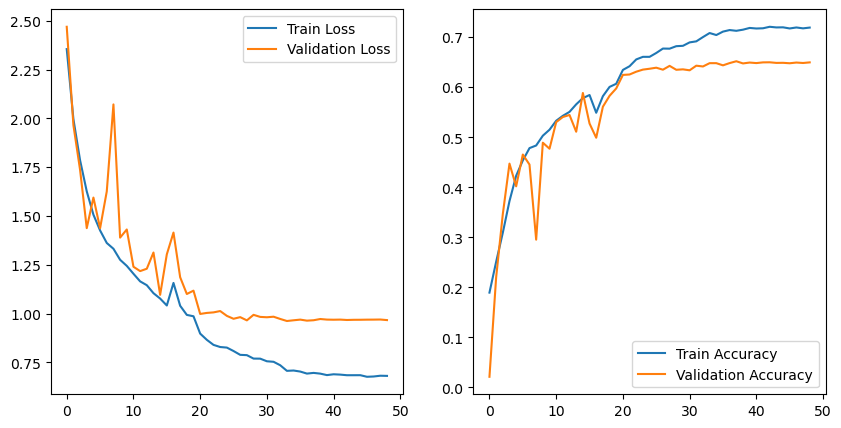

In [18]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()


Evaluasi Model

In [19]:
print("\n--- Evaluasi Model pada Data Uji Akhir ---")
model.load_weights('best_fer2013_model.keras') 
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss Pengujian Akhir: {loss:.4f}")
print(f"Akurasi Pengujian Akhir: {accuracy:.4f}")


--- Evaluasi Model pada Data Uji Akhir ---
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6275 - loss: 1.0731
Loss Pengujian Akhir: 0.9932
Akurasi Pengujian Akhir: 0.6505


In [32]:
print("y_test shape:", y_test.shape)
print("Unique shape:", len(y_test.shape))



y_test shape: (7178, 7)
Unique shape: 2


In [ ]:
y_true = np.argmax(y_test, axis=1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))



225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       958
           1       0.66      0.62      0.64       111
           2       0.54      0.42      0.47      1024
           3       0.88      0.83      0.86      1774
           4       0.55      0.70      0.62      1233
           5       0.55      0.46      0.50      1247
           6       0.72      0.80      0.76       831

    accuracy                           0.65      7178
   macro avg       0.64      0.64      0.63      7178
weighted avg       0.65      0.65      0.65      7178

Precision: 0.6367412196042738
Recall: 0.636018539032534
F1: 0.6323344293237183


<Figure size 800x600 with 0 Axes>

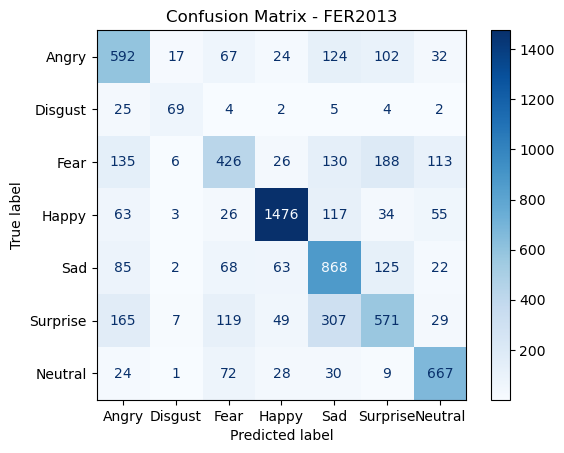

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - FER2013")
plt.show()
